
## Google Quick Draw prediction

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting the data

In [3]:
#! sudo /opt/anaconda3/bin/pip install kaggle --upgrade

In [4]:
#! mkdir -p ~/.kaggle/
#! mv ~/kaggle.json ~/.kaggle/

In [5]:
path = Path(Config.get_key('data_path')).expanduser()/'google-draw'
os.makedirs(path, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/google-draw')

In [6]:
#! kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip -p {path}  
#! kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv -p {path}    

In [7]:
#! unzip {path}/train_simplified.zip -d {path}/train

We only download the training data file for this lesson, but you can grab the test file if you want to make a late submission.

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it.

In [8]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/google-draw/test_simplified.csv'),
 PosixPath('/home/jupyter/.fastai/data/google-draw/txt'),
 PosixPath('/home/jupyter/.fastai/data/google-draw/train'),
 PosixPath('/home/jupyter/.fastai/data/google-draw/train_simplified.zip'),
 PosixPath('/home/jupyter/.fastai/data/google-draw/classes.pkl'),
 PosixPath('/home/jupyter/.fastai/data/google-draw/batch_stats_64.pkl'),
 PosixPath('/home/jupyter/.fastai/data/google-draw/batch_stats_128.pkl')]

In [9]:
path_txt = path / 'txt'

In [10]:
path_models = Path('/home/jupyter/models'); path_models.ls()

[PosixPath('/home/jupyter/models/tmp.pth'),
 PosixPath('/home/jupyter/models/res34-128-stage-2.pth'),
 PosixPath('/home/jupyter/models/res34-64-stage-1.pth'),
 PosixPath('/home/jupyter/models/res34-64-stage-2.pth'),
 PosixPath('/home/jupyter/models/res34-128-stage-1.pth')]

# Preprocessing

In [11]:
import cv2, json

In [12]:
BASE_SIZE = 256
def list2drawing(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

def drawing2tensor(drawing):
    rgb = cv2.cvtColor(drawing,cv2.COLOR_GRAY2RGB)
    rgb = rgb.transpose(2,0,1).astype(np.float32)
    return torch.from_numpy(rgb)

# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def map3(preds, targs):
    predicted_idxs = preds.sort(descending=True)[1]
    top_3 = predicted_idxs[:, :3]
    res = mapk([[t] for t in targs.cpu().numpy()], top_3.cpu().numpy(), 3)
    return torch.tensor(res)

def top_3_preds(preds): return np.argsort(preds.numpy())[:, ::-1][:, :3]

def top_3_pred_labels(preds, classes):
    top_3 = top_3_preds(preds)
    labels = []
    for i in range(top_3.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top_3[i]]))
    return labels

def create_submission(test_preds, test_dl, name):
    key_ids = [path.stem for path in test_dl.dataset.x.items]
    labels = top_3_pred_labels(test_preds, classes)
    sub = pd.DataFrame({'key_id': key_ids, 'word': labels})
    sub.to_csv(f'{path}/subs/{name}.csv.gz', index=False, compression='gzip')

In [13]:
NUM_SAMPLES_PER_CLASS = 1_000

In [14]:
os.makedirs(path /'txt', exist_ok=True)
os.makedirs(path /'txt'/'train', exist_ok=True)
os.makedirs(path /'txt'/'test', exist_ok=True)

In [15]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    klass = '_'.join(path.stem.split())
    (path_txt/'train'/klass).mkdir(exist_ok=True)
    for row in df.sample(NUM_SAMPLES_PER_CLASS).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized
        }
        with open(path_txt/'train'/klass/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id
        }
        with open(path_txt/'test'/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

In [16]:
#%time create_test_txts_from_df(path/'test_simplified.csv')

In [17]:
#%time for p in Path(path/'train').iterdir(): create_train_txts_from_df(p)

In [18]:
src_size = 512 // 8

In [19]:
sz = src_size // 1
bs = 1024

In [20]:
def create_func(path):
    with open(path) as f: j = json.load(f)
    drawing = list2drawing(j['drawing'], size=src_size)
    tensor = drawing2tensor(drawing)
    return Image(tensor.div_(255))

In [21]:
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms()

In [22]:
src = (ItemList.from_folder(path_txt/'train', create_func=create_func)
             .random_split_by_pct(0.2)
             .label_from_folder()
             .add_test(ItemList.from_folder(path_txt/'test', create_func=create_func))
      )

In [23]:
src.x._bunch = ImageDataBunch

In [24]:
data = (src
        .transform(tfms, sz=sz)
        .databunch(bs=bs)
        .normalize()
       )

In [25]:
#print(data.classes)
len(data.classes),data.c

(340, 340)

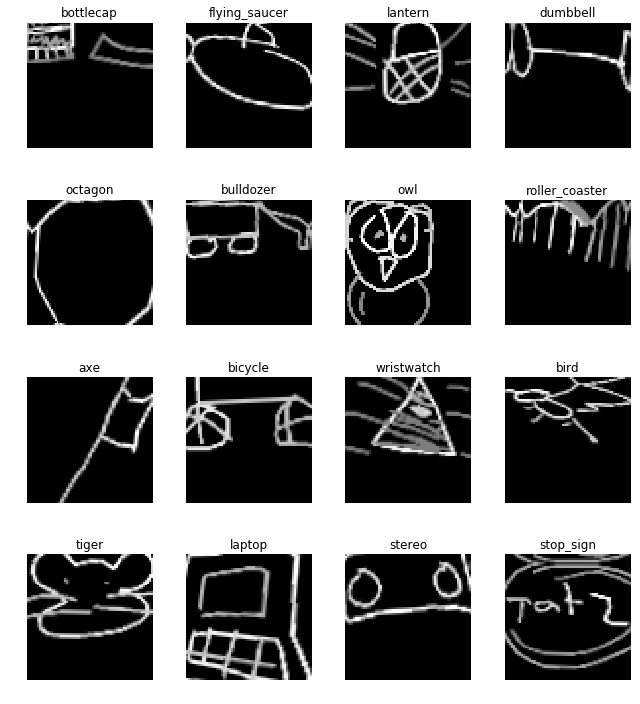

In [26]:
data.show_batch(rows=4)

## Training: resnet

In [27]:
name = f'res34-{sz}'

In [28]:
#arch = models.resnet50
arch = models.resnet34

In [29]:
metrics = [accuracy,map3]
#metrics = accuracy

In [30]:
learn = create_cnn(data, arch, metrics=metrics, model_dir = path_models)#.to_fp16()

In [31]:
#learn.load('res34-128-stage-2');

In [50]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


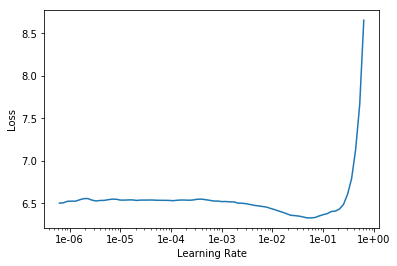

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
lr = 1e-02

In [99]:
learn.fit_one_cycle(3, slice(lr))

Total time: 09:37
epoch  train_loss  valid_loss  accuracy  map3    
1      1.358179    1.204422    0.682941  0.765922  (03:11)
2      1.259447    1.085682    0.716353  0.792961  (03:11)
3      1.140498    1.034698    0.729824  0.803059  (03:13)



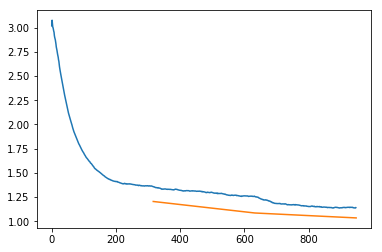

In [100]:
learn.recorder.plot_losses()

In [101]:
learn.save(f'{name}-stage-1')

## Results

In [102]:
#interp = ClassificationInterpretation.from_learner(learn)

In [103]:
#interp.plot_top_losses(9, figsize=(15,11))

## Unfreezing, fine-tuning, and learning rates

In [40]:
learn.load(f'{name}-stage-1');

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


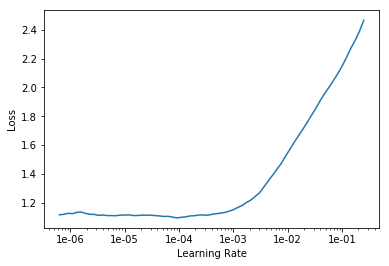

In [42]:
learn.lr_find()
learn.recorder.plot()

In [45]:
lrs = slice(1e-04, lr/10)

In [46]:
learn.fit_one_cycle(5, lrs) 

Total time: 22:39
epoch  train_loss  valid_loss  accuracy  map3    
1      1.182257    1.087388    0.712647  0.789490  (04:28)
2      1.158473    1.072602    0.725765  0.797382  (04:31)
3      0.949258    0.981611    0.748412  0.815814  (04:32)
4      0.712735    0.932550    0.762706  0.827314  (04:33)
5      0.536559    0.933871    0.767118  0.829480  (04:33)



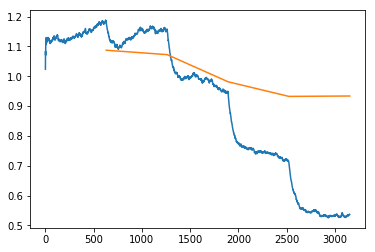

In [47]:
learn.recorder.plot_losses()

In [48]:
learn.save(f'{name}-stage-2')

## Generate submission

In [45]:
learn.load(f'{name}-stage-2');

In [46]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
#preds = learn.TTA(ds_type=DatasetType.Test)[0]
#preds,y,losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)

IndexError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 354, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 79, in __getitem__
    if isinstance(try_int(idxs), int): return self.get(idxs)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 228, in get
    o = super().get(i)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 55, in get
    item = self.items[i]
IndexError: index 68000 is out of bounds for axis 0 with size 68000
